# Retrieving, processing, and visualising MODIS data
### Plotting the 'MOD09A1 - MODIS/Terra Surface Reflectance 8-Day L3 Global 500m SIN Grid' dataset

### Links Used:
* Dataset used: https://catalogue.ceda.ac.uk/uuid/05a18921d3a44c89a9158809fd813eb3?jump=related-docs-anchor
* Guide to dataset: https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/MOD09A1#overview
* Guide pdf: https://salsa.umd.edu/files/MOD09_UserGuide_v1.4.pdf
* Understanding modis data and plotting: https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/modis-data-in-python/
* Web scraping functionality: https://www.selenium.dev/
* Web-driver functionality: https://github.com/SergeyPirogov/webdriver_manager

### Data Used:
\* signs used in the below list denote wildcard indexing.
* archive/neodc/modis/data/MOD09A1/collection6/\*/\*/\*/\*h18v03*
* archive/neodc/modis/data/MOD09A1/collection6/\*/\*/\*/\*h18v04*
* archive/neodc/modis/data/MOD09A1/collection6/\*/\*/\*/\*h19v03*
* archive/neodc/modis/data/MOD09A1/collection6/\*/\*/\*/\*h19v04*

### Prerequisites:
Before being able to run the below code, a suitable conda environment must be set up.
This environment must be set up to handle the modis files, and requires a variety of geospatial modules.
If you already have miniconda set up on your local PC all you need to do is set up the environment from the terminal.
The following code will be of use:
- $ conda create -n modis_env
- $ conda activate modis_env
- $ conda install -c conda-forge rioxarray
- $ conda install ipykernel
- $ conda install matplotlib
- $ conda install -c conda-forge geopandas
- $ conda install -c conda-forge earthpy
- $ conda install -c conda-forge bs4
- $ conda install -c conda-forge selenium
- $ pip install webdriver-manager

In [1]:
import os
import warnings
import math
import sys
import datetime
import requests
import shutil
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.ma as ma
import xarray as xr
import rioxarray as rxr
from shapely.geometry import mapping, box
from rasterio.plot import plotting_extent
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

## Tile Suitability Testing

Importing the tiles that may be useful to the area we are interested in:
* h18v03
* h18v04
* h19v03
* h19v04 

In [2]:
# Finding the extreme spatial bounds of the modis data.

# archive/neodc/modis/data/MOD09A1/collection6/2009/01/09/
modis_path1 = "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/ndmi_pre-processing/modis_downloading_testing/pre-downloaded/MOD09A1.A2009009.h18v03.006.2015186095829.hdf"
# h18v03 ^
modis_path2 = "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/ndmi_pre-processing/modis_downloading_testing/pre-downloaded/MOD09A1.A2009009.h18v04.006.2015186095816.hdf"
# h18v04 ^
modis_path3 = "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/ndmi_pre-processing/modis_downloading_testing/pre-downloaded/MOD09A1.A2009009.h19v03.006.2015186095607.hdf"
# h19v03 ^
modis_path4 = "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/ndmi_pre-processing/modis_downloading_testing/pre-downloaded/MOD09A1.A2009009.h19v04.006.2015186095704.hdf"
# h19v04 ^

modis_file1 = rxr.open_rasterio(modis_path1, masked=True)
# h18v03 ^
modis_file2 = rxr.open_rasterio(modis_path2, masked=True)
# h18v04 ^
modis_file3 = rxr.open_rasterio(modis_path3, masked=True)
# h19v03 ^
modis_file4 = rxr.open_rasterio(modis_path4, masked=True)
# h19v04 ^

In [3]:
# Printing the bounds from the attributes section of the xarray files.
print("File1 (h18v03) Bounds:")
print(f"N:{modis_file1.attrs['NORTHBOUNDINGCOORDINATE']}")
print(f"E:{modis_file1.attrs['EASTBOUNDINGCOORDINATE']}")
print(f"S:{modis_file1.attrs['SOUTHBOUNDINGCOORDINATE']}")
print(f"W:{modis_file1.attrs['WESTBOUNDINGCOORDINATE']}\n")

print("File2 (h18v04) Bounds:")
print(f"N:{modis_file2.attrs['NORTHBOUNDINGCOORDINATE']}")
print(f"E:{modis_file2.attrs['EASTBOUNDINGCOORDINATE']}")
print(f"S:{modis_file2.attrs['SOUTHBOUNDINGCOORDINATE']}")
print(f"W:{modis_file2.attrs['WESTBOUNDINGCOORDINATE']}\n")

print("File3 (h19v03) Bounds:")
print(f"N:{modis_file3.attrs['NORTHBOUNDINGCOORDINATE']}")
print(f"E:{modis_file3.attrs['EASTBOUNDINGCOORDINATE']}")
print(f"S:{modis_file3.attrs['SOUTHBOUNDINGCOORDINATE']}")
print(f"W:{modis_file3.attrs['WESTBOUNDINGCOORDINATE']}\n")

print("File4 (h19v04) Bounds:")
print(f"N:{modis_file4.attrs['NORTHBOUNDINGCOORDINATE']}")
print(f"E:{modis_file4.attrs['EASTBOUNDINGCOORDINATE']}")
print(f"S:{modis_file4.attrs['SOUTHBOUNDINGCOORDINATE']}")
print(f"W:{modis_file4.attrs['WESTBOUNDINGCOORDINATE']}\n")

# Setting up WSEN bound arrays for each of the files.
file1_wsen = np.array([modis_file1.attrs['WESTBOUNDINGCOORDINATE'], modis_file1.attrs['SOUTHBOUNDINGCOORDINATE'], 
                        modis_file1.attrs['EASTBOUNDINGCOORDINATE'], modis_file1.attrs['NORTHBOUNDINGCOORDINATE']])
file2_wsen = np.array([modis_file2.attrs['WESTBOUNDINGCOORDINATE'], modis_file2.attrs['SOUTHBOUNDINGCOORDINATE'], 
                        modis_file2.attrs['EASTBOUNDINGCOORDINATE'], modis_file2.attrs['NORTHBOUNDINGCOORDINATE']])
file3_wsen = np.array([modis_file3.attrs['WESTBOUNDINGCOORDINATE'], modis_file3.attrs['SOUTHBOUNDINGCOORDINATE'], 
                        modis_file3.attrs['EASTBOUNDINGCOORDINATE'], modis_file3.attrs['NORTHBOUNDINGCOORDINATE']])
file4_wsen = np.array([modis_file4.attrs['WESTBOUNDINGCOORDINATE'], modis_file4.attrs['SOUTHBOUNDINGCOORDINATE'], 
                        modis_file4.attrs['EASTBOUNDINGCOORDINATE'], modis_file4.attrs['NORTHBOUNDINGCOORDINATE']])

File1 (h18v03) Bounds:
N:59.9999999946118
E:20.0166666616087
S:49.9999999955098
W:0.0

File2 (h18v04) Bounds:
N:49.9999999955098
E:15.5702026309755
S:39.9999999964079
W:0.0

File3 (h19v03) Bounds:
N:59.9999999946118
E:40.016666656555
S:49.9999999955098
W:15.5572382657541

File4 (h19v04) Bounds:
N:49.9999999955098
E:31.1274408967296
S:39.9999999964079
W:13.0540728914638



We will now find the extent of the project area by looking at our original shape files.

In [4]:
# Finding the extreme spatial bounds of the project area. n, e, s, w
shp_plot_locations = gpd.read_file('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/ndmi_pre-processing/modis_downloading_testing/ShapeFiles/whole_map.shp')
project_wsen = shp_plot_locations.total_bounds

print(f"Project Bounds:")
print(f"N:{shp_plot_locations.total_bounds[3]}")
print(f"E:{shp_plot_locations.total_bounds[2]}")
print(f"S:{shp_plot_locations.total_bounds[1]}")
print(f"W:{shp_plot_locations.total_bounds[0]}")

Project Bounds:
N:53.04445372901561
E:32.10002856023667
S:50.50148427738854
W:22.944695970820717


Now we will compare the project area against the bounds we found for each of the tiles we suspect as being of use. Hopefully one of the tiles will encompass the entirety of the area we require, which would mean we don't have to stitch any tiles together during processing.

In [5]:
# Creating a function that can check the suitability of tiles, to see whether they encompass the complete bounds of the project area.
def tile_suitability_checker(tile_bounds, project_bounds):
    """
    Returns a string detailing the suitability of a tile passed to it.

    Keyword arguments:
    tile_bounds -- n, e, s, w bounds of the tile
    project_bounds -- n, e, s, w bounds of the project
    
    Prerequisites: 
    - none (simply python...)
    """
    i = 0
    west_check = 0
    south_check = 0
    east_check = 0
    north_check = 0
    for _,__ in zip(tile_bounds, project_bounds):
        if i == 0:
            if _ < __:
                west_check = 1
        if i == 1:
            if _ < __:
                south_check = 1
        if i == 2:
            if _ > __:
                east_check = 1
        if i == 3:
            if _ > __:
                north_check = 1
        i += 1
    
    if west_check + south_check + east_check + north_check == 4:
        return("Tile suitable")
    else:
        return("Tile unsuitable")

print(f"File1 (h18v03): {tile_suitability_checker(file1_wsen, project_wsen)}")
print(f"File2 (h18v04): {tile_suitability_checker(file2_wsen, project_wsen)}")
print(f"File3 (h19v03): {tile_suitability_checker(file3_wsen, project_wsen)}")
print(f"File4 (h19v04): {tile_suitability_checker(file4_wsen, project_wsen)}")

File1 (h18v03): Tile unsuitable
File2 (h18v04): Tile unsuitable
File3 (h19v03): Tile suitable
File4 (h19v04): Tile unsuitable


## Tile Cropping

Having found tile3, aka h19v03 to be suitably encompassing of the entire study area, we will now pursue the cropping of the data to the correct spatial bounds, before looking at the overarching download and filing system we may need to design next.

In [6]:
# Opening specific bounds from MODIS files in an xarray format.
desired_bands = ["sur_refl_b02", "sur_refl_b06"]
modis_bands_pre = rxr.open_rasterio(modis_path3, masked=True, variable=desired_bands)
modis_bands_pre

<xarray.Dataset>
Dimensions:       (y: 2400, x: 2400, band: 1)
Coordinates:
  * y             (y) float64 6.671e+06 6.671e+06 ... 5.56e+06 5.56e+06
  * x             (x) float64 1.112e+06 1.113e+06 ... 2.223e+06 2.224e+06
  * band          (band) int64 1
    spatial_ref   int64 0
Data variables:
    sur_refl_b02  (band, y, x) float32 ...
    sur_refl_b06  (band, y, x) float32 ...
Attributes: (12/174)
    ASSOCIATEDINSTRUMENTSHORTNAME.1:    MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:      Terra
    ASSOCIATEDSENSORSHORTNAME.1:        MODIS
    AUTOMATICQUALITYFLAG.1:             Passed
    AUTOMATICQUALITYFLAGEXPLANATION.1:  Always Passed
    CHARACTERISTICBINANGULARSIZE250M:   7.5
    ...                                 ...
    SPSOPARAMETERS:                     2015
    SYSTEMFILENAME:                     MOD09GQ.A2009009.h19v03.006.201518606...
    TileID:                             51019003
    VERSIONID:                          6
    VERTICALTILENUMBER:                 3
    WESTBOUNDINGCOORDINATE:             15.5572382657541

In [7]:
# Using the shape file of the projects bounds to provide bounding boxes that can be applied to the trimming of xarray datasets.
project_area_boundary_path = os.path.join("/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/ndmi_pre-processing/modis_downloading_testing/ShapeFiles/whole_map.shp")
project_area_boundary = gpd.read_file(project_area_boundary_path)
project_area_sin = project_area_boundary.to_crs(modis_bands_pre.rio.crs)
project_area_bound_box = [box(*project_area_sin.total_bounds)]

modis_clip_geometry = modis_bands_pre.rio.clip(project_area_sin.geometry, all_touched=True, from_disk=True)

modis_clip = modis_bands_pre.rio.clip(project_area_bound_box, all_touched=True, from_disk=True)

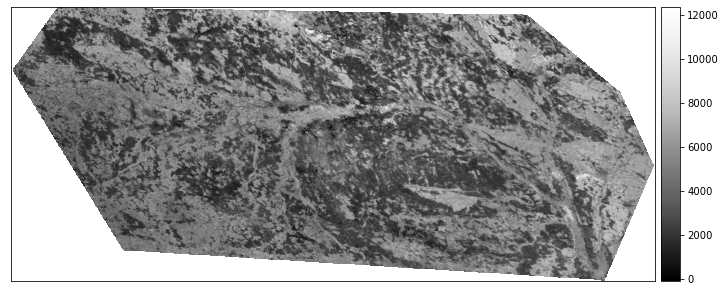

In [8]:
# Plotting the sharp geometric trim of the project area.
ep.plot_bands(modis_clip_geometry.sur_refl_b02)
plt.show()

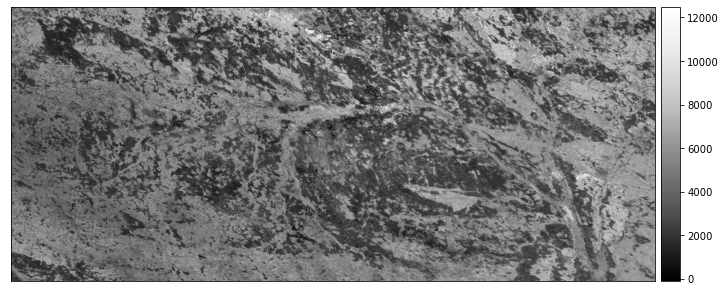

In [9]:
# Plotting the simple box trim of the project area.
ep.plot_bands(modis_clip.sur_refl_b02)
plt.show()

## Tile Compilation
Scripts for compiling multiple files (days within a month) into a single xarray file for each month.
MODIS provides multiple tiles for each month, but we would like to have a single tile for each month, this script provides a method for averaging across the tiles in a month to provide an average tile that can be of sue to us.

In [11]:
# Specifying the directory where all the tiles are currently stored.
directory = '/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/ndmi_pre-processing/modis_downloading_testing/pre-downloaded/h19v03'

def path_assigner(directory):
    """
    Iterates through the files in the directory passed to it and generates an array of all the paths within the folder.

    Keyword arguments:
    directory -- path to local folder full of all the modis files.
    
    Prerequisites: 
    - os
    """
    i = 0
    path_array = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        path_array.append(f)
        i += 1
    return(path_array)

# Assign paths for the files in the directory.
path_array = path_assigner(directory)

In [12]:
def tile_opener(path_array, desired_bands):
    """
    Function that takes an array of all the paths and an array of all the desired bands, and provides and array of all the files
    opened in an xarray dataset format.

    Keyword arguments:
    path_array -- an array of all the paths for files within the folder in question.
    desired_bands -- a short array of all the bands we'd like to retrieve from the files.

    Prerequisites:
    - xarray
    - rasterio
    - rioxarray
    """
    tile_array = []
    for path in path_array:
        tile_array.append(rxr.open_rasterio(path, masked=True, variable=desired_bands))
    return(tile_array)

desired_bands = ["sur_refl_b02", "sur_refl_b06"]
tile_array = tile_opener(path_array, desired_bands)

In [13]:
# Defining the boundaries of project area using geopandas.
project_area_boundary_path = "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/ndmi_pre-processing/modis_downloading_testing/ShapeFiles/whole_map.shp"
project_area_boundary = gpd.read_file(project_area_boundary_path)
project_area_sin = project_area_boundary.to_crs(tile_array[0].rio.crs)
project_area_bound_box = [box(*project_area_sin.total_bounds)]

def rough_cropper(tile_array, project_area_bound_box):
    """
    Function that takes an array of tiles and the project bounds and
    returns another tile array that has been suitably cropped geospatially.

    Keyword arguments:
    tile_array -- an array of all the tiles opened.
    project_area_bound_box -- a rough bounding box with which to geospatially crop each of the xarray files presented.

    Prerequisites:
    - xarray
    - rasterio
    - rioxarray
    """
    cropd_tile_array = []
    for _ in tile_array:
        cropd_tile_array.append(_.rio.clip(project_area_bound_box, all_touched=True, from_disk=True))
    return cropd_tile_array

cropd_tile_array = rough_cropper(tile_array, project_area_bound_box)

In [14]:
# An empty tile entitled avg_tile is defined, which will be filled with the averaged values
# across the multiple tiles for a single month.
avg_tile = cropd_tile_array[0].assign(sur_refl_b02_avg=xr.full_like(cropd_tile_array[0].sur_refl_b02, 5000))
avg_tile = avg_tile.assign(sur_refl_b06_avg=xr.full_like(cropd_tile_array[0].sur_refl_b06, 5000))
avg_tile = avg_tile.drop(labels=["sur_refl_b02","sur_refl_b06"])

def tile_averager(cropd_tile_array, avg_tile):
    """
    Function that takes the array of cropped tiles and the empty avg_tile xarray object, before returning
    the newly filled avg_tile which has averaged across the multiople tiles within a month.

    Keyword arguments:
    cropd_tile_array -- an array of all the cropped tiles for a month.
    avg_tile -- the empty tile xarray dataset to be filled with the average pixel values.

    Prerequisites:
    - xarray

    """
    i = 0
    for _ in avg_tile.y.values:
        j = 0
        for __ in avg_tile.x.values:
            b2_vals = []
            b6_vals = []
            for ___ in cropd_tile_array:
                b2_vals.append(___.sur_refl_b02.values[0, i, j])
                b6_vals.append(___.sur_refl_b06.values[0, i, j])
    
            b2_average_val = sum(b2_vals) / len(b2_vals)
            b6_average_val = sum(b6_vals) / len(b6_vals)
    
            avg_tile.sur_refl_b02_avg.values[0, i, j] = b2_average_val
            avg_tile.sur_refl_b06_avg.values[0, i, j] = b6_average_val
            j += 1
        i += 1
    return avg_tile

avg_tile = tile_averager(cropd_tile_array, avg_tile)

In [15]:
def fine_cropper(avg_tile, project_area_sin):
    """
    Function for cropping a tile to the exact geometry of the project area.

    Keyword arguments:
    avg_tile -- the averaged tile for a month.
    project_area_sin -- the exact project area bounds

    Prerequisites:
    - xarray
    - rasterio
    - rioxarray
    """
    fcropd_avg_tile = avg_tile.rio.clip(project_area_sin.geometry, all_touched=True, from_disk=True)
    return fcropd_avg_tile

fcropd_avg_tile = fine_cropper(avg_tile, project_area_sin)

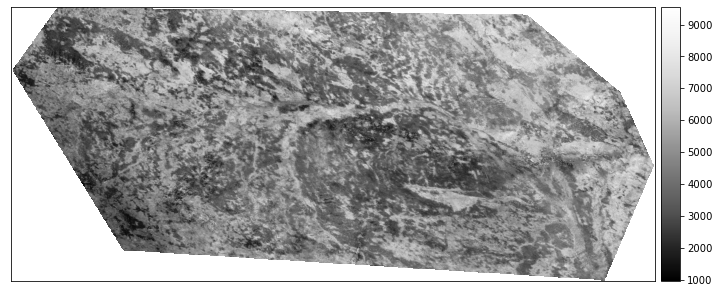

In [16]:
ep.plot_bands(fcropd_avg_tile.sur_refl_b02_avg)
plt.show()

## Saving and Accessing NetCDF

In [17]:
# Saving an xarray file to a single netcdf file locally
fcropd_avg_tile.to_netcdf("/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/ndmi_pre-processing/modis_downloading_testing/output/test.nc")

In [18]:
# Opening a the previously generated netCDF file.
ds_disk = xr.open_dataset("/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/ndmi_pre-processing/modis_downloading_testing/output/test.nc")

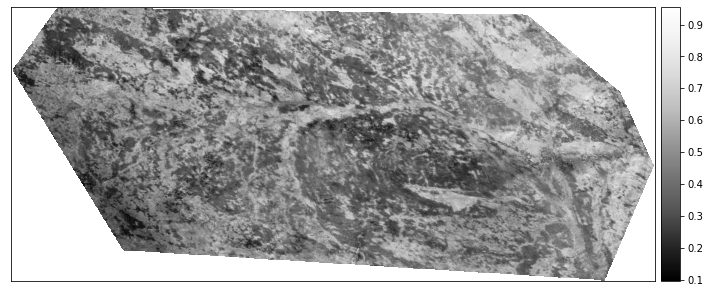

In [19]:
# Plotting the saved netcdf file.
ep.plot_bands(ds_disk.sur_refl_b02_avg)
plt.show()

## Downloading, Staging, Processing, Filing
Roughly drafted scripts that would provide functionality for downloading files from CEDA archive and placing them in the right places within the JASMIN workspaces.

In [20]:
# Script to estimate the scale of data we are generating during the download, processing, and filing process.
one_tile_size = 80

one_month_tiles = 4
one_month_size = one_tile_size * one_month_tiles

one_year_months = 12
one_year_size = one_month_size * one_year_months

one_dataset_years = 2022 - 2009
one_dataset_size = one_year_size * one_dataset_years

# print(f"One tile: {one_tile_size/1000} GB")
# print(f"One month: {one_month_size/1000} GB")
# print(f"One year: {one_year_size/1000} GB")
print(f"One dataset with all the tiles necessary for processing: {one_dataset_size/1000} GB")

averaged_month_tiles = 1
one_averaged_tile_size = one_tile_size * averaged_month_tiles * one_year_months
one_dataset_size = one_averaged_tile_size * one_dataset_years
print(f"One dataset with only the processed tiles: {one_dataset_size/1000} GB")

One dataset with all the tiles necessary for processing: 49.92 GB
One dataset with only the processed tiles: 12.48 GB


In [21]:
# Setting up the file structure in the output folder.
def output_folder_file_structurer(output_path, start_year, end_year, start_month, end_month):
    """
    A function that takes a local folder and creates a file keeping structure within it. This provides a
    structure into which files can be deposited.

    Keyword arguments:
    output_path -- The folder path into which we will create a file foldering structure.
    start_year -- The start year, start highest folder on the structures hierarchy.
    end_year -- The end year, the end highest folder on the structures hierarchy.
    start_month -- The start month, start lowest folder on the structure hierarchy.
    end_month -- The end month, the end lowest folder on the structure hierarchy.

    Prerequisites:
    - os
    """
    nr_of_years = end_year - start_year
    os.chdir(output_path)
    for _ in range(start_year, end_year+1):
        path_checker = os.path.exists(str(output_path) + "/" + str(_))
        if path_checker == True:
            pass
        else:
            os.mkdir(str(_))


    for _ in range(start_year, end_year+1):
        os.chdir(str(output_path) + "/" + str(_))
        for __ in range(start_month, end_month+1):
            year = str(_)
            month = str(__)
            if len(month) == 1:
                month = "0" + month
            else:
                month = month
            path_checker = os.path.exists(str(output_path) + "/" + year + "/" + month)
            if path_checker == True:
                pass
            else:
                os.mkdir(month)

output_folder_path = "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/ndmi_pre-processing/modis_downloading_testing/output"
start_year = 2009
end_year = 2022
start_month = 1
end_month = 12
output_folder_file_structurer(output_folder_path, start_year, end_year, start_month, end_month)

In [22]:
# Tag finder (day finder) that works by looking at the html of ceda pages and digs out relevant days within months.
def tag_finder(soup):
    """
    Function that digs through webpage html to find useful strings between tags of interest. It returns the exact day numbers within
    months of interest.

    Keyword arguments:
    soup -- The raw html downloaded from a specific webpage within the CEDA website.

    Prerequisites:
    - bs4
    """
    tags_found = soup.select("div[id=root] > div > div > div > table > tbody > tr > td > a")
    tag_list = []
    for _ in tags_found:
        tag = str(_)
        if tag[0:7] == "<a href":
            tag_list.append(tag[59:61])
    return(tag_list)

In [23]:
# Script for opening ceda monthly pages for each of the years in question,
# passes the html to the tag_finder so that it can obtain the days we need to look for in each of the months.
# All years,months,days of use are placed in a df 'ceda_path_df'
# CAUTION: This script automatically opens and runs a chrome browser to scrape information, think before you run!

def ceda_day_finder(ceda_path_df, start_year, end_year, start_month, end_month, driver):
    """
    Function that carries out the process of web scraping throught multiple pages within the CEDA archive webpage.
    It makes use of the tag_finder function to obtain the year month and day of all files of interest, so that exact file paths
    can be generated later, which will allow the doigging up of filenames under year>month>day.

    Keyword arguments:
    ceda_path_df -- empty pandas dataframe into which scraped information can be placed at will within the function.
    start_year -- The start year, start highest folder on the structures hierarchy.
    end_year -- The end year, the end highest folder on the structures hierarchy.
    start_month -- The start month, start lowest folder on the structure hierarchy.
    end_month -- The end month, the end lowest folder on the structure hierarchy.

    Prerequisites:
    - selenium
    - bs4
    - webdriver-manager
    """
    for _ in range(start_year, end_year):
        for __ in range(start_month, end_month+1):
            year = str(_)
            month = str(__)

            if len(month) == 1:
                month = "0" + month
            else:
                month = month

            path_base = "https://data.ceda.ac.uk/neodc/modis/data/MOD09A1/collection6/"
            path_final = path_base + year + "/" + month

            driver.get(path_final)
            time.sleep(0.5)
            html = driver.execute_script("return document.documentElement.innerHTML;")
            soup = BeautifulSoup(html, 'html.parser')

            tile_filename_list = tag_finder(soup)

            # print(f"{year} : {month} : {tile_filename_list}")

            for ___ in tile_filename_list:
                new_data_df = pd.DataFrame([[year, month, ___]], columns=['Year', 'Month', 'Day'])
                ceda_path_df = pd.concat([ceda_path_df, new_data_df])
    return(ceda_path_df)

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

column_names = ["Year", "Month", "Day"]
ceda_path_df = pd.DataFrame(columns = column_names)
ceda_path_df = ceda_day_finder(ceda_path_df, start_year, end_year, start_month, end_month, driver)

# Format the table full of useful ceda paths
ceda_path_df['Day_Month_Year'] = ceda_path_df['Day'] + "/" + ceda_path_df['Month'] + "/" + ceda_path_df['Year']
datetime_series = pd.to_datetime(ceda_path_df["Day_Month_Year"], dayfirst=True)
datetime_index = pd.DatetimeIndex(datetime_series.values)
ceda_path_df = ceda_path_df.set_index(datetime_index)
ceda_path_df = ceda_path_df.drop(["Day_Month_Year"], axis=1)
ceda_path_df = ceda_path_df.drop(["Day"], axis=1)
ceda_path_df = ceda_path_df.drop(["Month"], axis=1)
ceda_path_df = ceda_path_df.drop(["Year"], axis=1)
ceda_path_df["tile_filename"] = np.nan
ceda_path_df



====== WebDriver manager ======
Current google-chrome version is 99.0.4844
Get LATEST chromedriver version for 99.0.4844 google-chrome
There is no [mac64_m1] chromedriver for browser  in cache
Trying to download new driver from https://chromedriver.storage.googleapis.com/99.0.4844.51/chromedriver_mac64_m1.zip
Driver has been saved in cache [/Users/thomasdodd/.wdm/drivers/chromedriver/mac64_m1/99.0.4844.51]


,tile_filename
2009-01-09,NaN
2009-01-17,NaN
2009-01-25,NaN
2009-02-02,NaN
2009-02-10,NaN
...,...
2021-10-16,NaN
2021-10-24,NaN
2021-11-01,NaN
2021-11-25,NaN


In [24]:
# Secondary rage finder, which finds exact filename of h19v03 tiles.
def tile_tag_finder(soup):
    """
    Function for digging through raw html; finds and returns the names of specific files.

    Keyword arguments:
    soup -- The raw html downloaded from a specific webpage within the CEDA website.

    Prerequisites:
    - bs4
    """
    tags_found = soup.select("div[id=root] > div > div > div > table > tbody > tr > td > a")
    tile_filename = ""
    for _ in tags_found:
        tag = str(_)
        if tag[97:103] == "h19v03":
            tile_filename = tag[80:125]
    return(tile_filename)

In [25]:
def ceda_filename_finder(ceda_path_df, driver):
    """
    Function that carries out the process of web scraping throught multiple pages within the CEDA archive webpage.
    It makes use of the tag_finder function to obtain the exact file names of tile/files of interest, so that exact file paths
    can be generated later, which will allow the digging up of filenames under year>month>day>filename.
    Returns a pandas dataframe with the all names of the files of interest and their timestamps.

    Keyword arguments:
    ceda_path_df -- pandas dataframe into which scraped information can be placed at will within the function.
    driver -- the driver originally initiated in one of the previous functions is passed to thhis function, so that
    chrome can be effectively manipulated by selenium.

    Prerequisites:
    - selenium
    - bs4
    - webdriver-manager
    """
    for _ in ceda_path_df.index:
        index_value = _
        year = str(_.year)
        month = str(_.month)
        day = str(_.day)

        if len(month) == 1:
            month = "0" + month
        else:
            month = month

        if len(day) == 1:
            day = "0" + day
        else:
            day = day

        path_base = "https://data.ceda.ac.uk/neodc/modis/data/MOD09A1/collection6/"
        path_final = path_base + year + "/" + month + "/" + day

        driver.get(path_final)
        time.sleep(0.5)
        html = driver.execute_script("return document.documentElement.innerHTML;")
        soup = BeautifulSoup(html, 'html.parser')

        tile_filename = tile_tag_finder(soup)

        # print(f"{index_value} : {str(tile_filename)}")

        ceda_path_df.at[index_value, 'tile_filename'] = str(tile_filename)
    return(ceda_path_df)

ceda_path_df = ceda_filename_finder(ceda_path_df, driver)
ceda_path_df

,tile_filename
2009-01-09,MOD09A1.A2009009.h19v03.006.2015186095607.hdf
2009-01-17,MOD09A1.A2009017.h19v03.006.2015186102630.hdf
2009-01-25,MOD09A1.A2009025.h19v03.006.2015186103012.hdf
2009-02-02,MOD09A1.A2009033.h19v03.006.2015186095541.hdf
2009-02-10,MOD09A1.A2009041.h19v03.006.2015187104120.hdf
...,...
2021-10-16,MOD09A1.A2021289.h19v03.006.2021299111439.hdf
2021-10-24,MOD09A1.A2021297.h19v03.006.2021306213053.hdf
2021-11-01,MOD09A1.A2021305.h19v03.006.2021314063936.hdf
2021-11-25,MOD09A1.A2021329.h19v03.006.2021338212612.hdf


### NOTE:
The rest of the code is draft and not incomplete, it aims to provide a basis for .py scripts that can be run in
JASMIN that would allow for all of the processes designed above to be implemented at once.
A final .py and .sh script will be made available on the GitHub page for this project, although the functionality
will likely be unproven.

In [32]:
# ceda_path_df = ceda_path_df.dropna()
# csv_path = "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/ndmi_pre-processing/modis_downloading_testing/script/tiles_needed.csv"
# ceda_path_df.to_csv(csv_path)

In [26]:
# iterate through each of the months data
# print(ceda_path_df.iat[0,0])

MOD09A1.A2009009.h19v03.006.2015186095607.hdf


In [27]:
# # Function required for downloading files to the staging area.
# def staging_mechanism(year_cmd, month_cmd, day_cmd, tile_cmd, staging_path):
#     staging_path_apres_dl = staging_path + "/dap.ceda.ac.uk/neodc/modis/data/MOD09A1/collection6/"
#     top_of_dl_path = "dap.ceda.ac.uk"

#     base_cmd = "wget -e robots=off --mirror --no-parent -r https://dap.ceda.ac.uk/neodc/modis/data/MOD09A1/collection6/"
#     final_cmd = base_cmd + year_cmd + "/" + month_cmd + "/" + day_cmd + "/" + tile_cmd

#     os.chdir(staging_path)
#     os.system(final_cmd)
#     time.sleep(10)

#     src_file_obj=open((staging_path_apres_dl + year_cmd + "/" + month_cmd + "/" + day_cmd + "/" + tile_cmd), 'rb')
#     targ_file_obj= open((staging_path + "/" + tile_cmd) , 'wb')
#     shutil.copyfileobj( src_file_obj , targ_file_obj )

#     shutil.rmtree(staging_path + "/" + top_of_dl_path)

In [28]:
# Function required for removing all files from the staging area.
# def stage_cache_clearer(staging_path):
    # for f in os.listdir(staging_path):
        # os.remove(os.path.join(staging_path, f))

In [29]:
# # column_names = ["Year", "Month", "Day", "Tile_Name"]
# # full_ceda_path_df = pd.DataFrame(columns = column_names)

# staging_path = "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/ndmi_pre-processing/modis_downloading_testing/staging"

# last_month = "01"
# for _ in ceda_path_df.index:
#     current_month = str(_.month)
#     if len(current_month) == 1:
#         current_month = "0" + current_month
#     else:
#         current_month = current_month

#     # year_month_day = str(_)
#     index_value = _
#     year = str(_.year)
#     month = str(_.month)
#     day = str(_.day)
#     tile = str(ceda_path_df.at[index_value, "tile_filename"])

#     if len(month) == 1:
#         month = "0" + month
#     else:
#         month = month

#     if len(day) == 1:
#         day = "0" + day
#     else:
#         day = day

#     if current_month == last_month:
#         print("Month hasn't changed.")
#         # Carry out staging of files.
#         staging_mechanism(year, month, day, tile, staging_path)
#     else:
#         print("Month has changed.")
#         # Carry out processing and placement before clearing staging cache.
#         # stage_cache_clearer(staging_path)
#         break

#     last_month = str(_.month)